# Projeto: Classificação de Gatos e Cachorros

**Objetivo**: Implementar e comparar três abordagens de classificação de imagens:
1. Embeddings CLIP + KNN
2. Classificação com LLM (Gemini)
3. Ensemble dos dois métodos

**Visualização**: T-SNE para análise da separabilidade dos embeddings

## Fase 1: Setup e Configuração

In [1]:
# Célula 1: Importações
import os
import time
import pickle
from pathlib import Path
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# ML & Embeddings
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    accuracy_score, silhouette_score
)
from sklearn.model_selection import train_test_split

# LLM
import google.generativeai as genai
from google.generativeai.types import HarmCategory, HarmBlockThreshold

# Dataset
import kagglehub

print("✅ Todas as bibliotecas importadas com sucesso!")

✅ Todas as bibliotecas importadas com sucesso!


In [2]:
# Célula 2: Configuração Global

# === CONFIGURAÇÃO DO PROJETO ===

# Parâmetros do Dataset
NUM_SAMPLES_PER_CLASS = 500      # Total: 1000 imagens
TRAIN_TEST_SPLIT = 0.8           # 800 train, 200 test
LLM_TEST_SUBSET = 100            # Apenas 100 para LLM (rate limit!)
RANDOM_STATE = 42

# Modelos
CLIP_MODEL = 'clip-ViT-B-32'     # 512 dimensões
GEMINI_MODEL = 'gemini-2.0-flash'  # ✅ MODELO ESTÁVEL (200 RPD, não experimental!)

# Parâmetros de Embedding
BATCH_SIZE = 32

# Parâmetros de T-SNE
TSNE_PERPLEXITY = 30
TSNE_N_ITER = 1000

# Parâmetros de KNN
KNN_K = 5
KNN_METRIC = 'cosine'

# Rate Limiting LLM (Gemini Free Tier: 15 RPM)
GEMINI_REQUESTS_PER_MINUTE = 15
SLEEP_BETWEEN_REQUESTS = 60 / GEMINI_REQUESTS_PER_MINUTE + 0.5  # 4.5s
CHECKPOINT_INTERVAL = 20         # Salvar a cada 20 requests

# Paths - CORRIGIDO: usar diretório atual (.)
BASE_DIR = Path('.')  # Diretório atual onde o notebook está
IMAGES_DIR = BASE_DIR / 'images'
RESULTS_DIR = BASE_DIR / 'results'
CACHE_DIR = BASE_DIR / 'cache'

# Criar diretórios
for dir_path in [IMAGES_DIR, RESULTS_DIR, CACHE_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

# API Key (variável de ambiente ou .env)
from dotenv import load_dotenv
load_dotenv()
GEMINI_API_KEY = os.getenv('GEMINI_API_KEY')

if not GEMINI_API_KEY:
    print("⚠️  AVISO: GEMINI_API_KEY não encontrada! Defina em .env ou variável de ambiente.")

print("✅ Configuração completa!")
print(f"   - Dataset: {NUM_SAMPLES_PER_CLASS * 2} imagens")
print(f"   - LLM subset: {LLM_TEST_SUBSET} imagens (~{LLM_TEST_SUBSET * SLEEP_BETWEEN_REQUESTS / 60:.1f} min)")
print(f"   - BASE_DIR: {BASE_DIR.resolve()}")

✅ Configuração completa!
   - Dataset: 1000 imagens
   - LLM subset: 100 imagens (~7.5 min)
   - BASE_DIR: C:\rocketseat\ftr\aulas\f2_n6_semantic-search-and-data-classification\src\project1


## Fase 2: Obtenção e Preparação do Dataset

In [3]:
# Célula 3: Download do Dataset via KaggleHub
print("📥 Baixando dataset via KaggleHub...")
dataset_path = kagglehub.dataset_download("tongpython/cat-and-dog")
print(f"✅ Dataset baixado em: {dataset_path}")

📥 Baixando dataset via KaggleHub...
✅ Dataset baixado em: C:\Users\Usuário\.cache\kagglehub\datasets\tongpython\cat-and-dog\versions\1


In [4]:
# Célula 4: Sampling Balanceado
import random
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

# Listar imagens por classe (ajustar pattern conforme estrutura do dataset)
dataset_root = Path(dataset_path)

# Tentar diferentes padrões de estrutura
cat_patterns = ['**/cat*.jpg', '**/cat*.png', '**/Cat*.jpg', '**/cats/*.jpg']
dog_patterns = ['**/dog*.jpg', '**/dog*.png', '**/Dog*.jpg', '**/dogs/*.jpg']

cats = []
for pattern in cat_patterns:
    cats.extend(list(dataset_root.glob(pattern)))
    if len(cats) > 0:
        break

dogs = []
for pattern in dog_patterns:
    dogs.extend(list(dataset_root.glob(pattern)))
    if len(dogs) > 0:
        break

# Remover duplicatas e fazer sampling
cats = list(set(cats))[:NUM_SAMPLES_PER_CLASS]
dogs = list(set(dogs))[:NUM_SAMPLES_PER_CLASS]

print(f"Imagens encontradas - Cats: {len(cats)}, Dogs: {len(dogs)}")

# Criar DataFrame
data = []
for path in cats:
    data.append({'path': str(path), 'label': 'cat'})
for path in dogs:
    data.append({'path': str(path), 'label': 'dog'})

df = pd.DataFrame(data)

df = df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

print(f"\n✅ Dataset preparado: {len(df)} imagens")
print(df['label'].value_counts())

Imagens encontradas - Cats: 500, Dogs: 500

✅ Dataset preparado: 1000 imagens
label
dog    500
cat    500
Name: count, dtype: int64


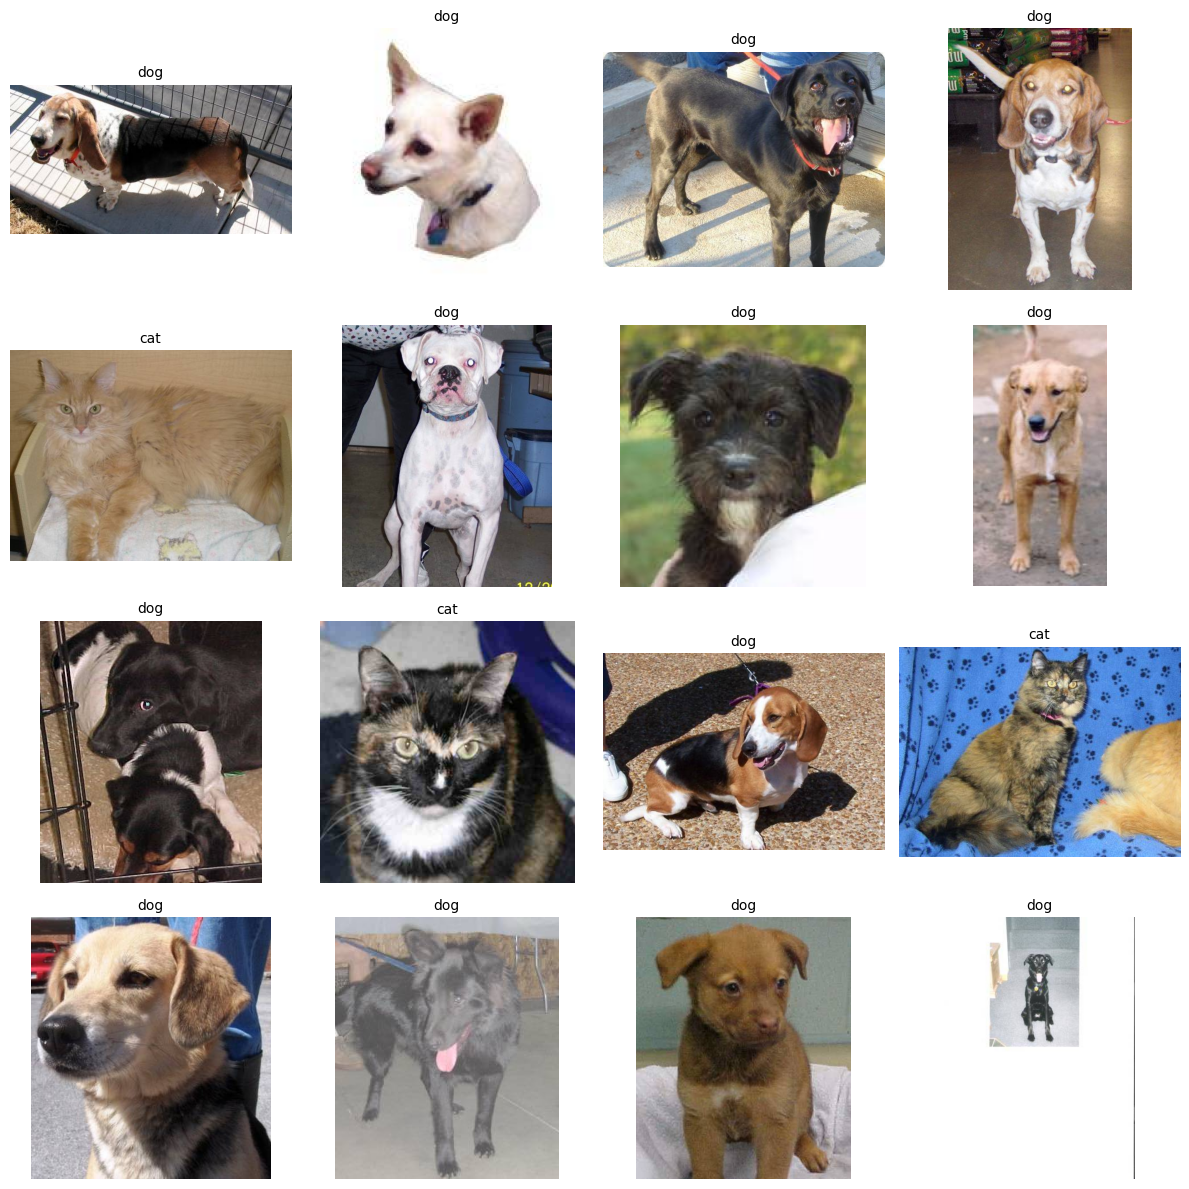

✅ Visualização salva em: results\sample_images.png


In [5]:
# Célula 5: Visualização Exploratória
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i, ax in enumerate(axes.flat):
    if i < len(df):
        try:
            img = Image.open(df.iloc[i]['path'])
            ax.imshow(img)
            ax.set_title(f"{df.iloc[i]['label']}", fontsize=10)
        except Exception as e:
            ax.text(0.5, 0.5, 'Erro ao carregar', ha='center')
        ax.axis('off')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'sample_images.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"✅ Visualização salva em: {RESULTS_DIR / 'sample_images.png'}")

## Fase 3: Parte 1 - Embeddings, KNN e T-SNE

In [6]:
# Célula 6: Carregar Modelo CLIP
print("🔄 Carregando modelo CLIP...")
clip_model = SentenceTransformer(CLIP_MODEL)

# Obter dimensionalidade de forma robusta
try:
    embedding_dim = clip_model.get_sentence_embedding_dimension()
except:
    # Fallback: gerar um embedding de teste para descobrir dimensão
    test_embedding = clip_model.encode("test")
    embedding_dim = len(test_embedding)

print(f"✅ Modelo carregado: {CLIP_MODEL} ({embedding_dim}D)")

🔄 Carregando modelo CLIP...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


✅ Modelo carregado: clip-ViT-B-32 (NoneD)


In [7]:
# Célula 7: Gerar Embeddings (com cache)
embeddings_cache = CACHE_DIR / 'embeddings.pkl'

if embeddings_cache.exists():
    print("📂 Carregando embeddings do cache...")
    with open(embeddings_cache, 'rb') as f:
        embeddings = pickle.load(f)
else:
    print("🔄 Gerando embeddings (pode demorar ~2-3 min)...")
    images = []
    valid_indices = []
    
    for idx, path in enumerate(tqdm(df['path'], desc="Carregando imagens")):
        try:
            img = Image.open(path)
            if img.mode != 'RGB':
                img = img.convert('RGB')
            images.append(img)
            valid_indices.append(idx)
        except Exception as e:
            print(f"⚠️ Erro ao carregar {path}: {e}")
    
    # Filtrar DataFrame apenas com imagens válidas
    df = df.iloc[valid_indices].reset_index(drop=True)
    
    embeddings = clip_model.encode(images, batch_size=BATCH_SIZE, 
                                     show_progress_bar=True, convert_to_numpy=True)
    
    # Salvar cache
    with open(embeddings_cache, 'wb') as f:
        pickle.dump(embeddings, f)
    print(f"💾 Embeddings salvos em cache: {embeddings_cache}")

print(f"✅ Embeddings: {embeddings.shape}")

📂 Carregando embeddings do cache...
✅ Embeddings: (1000, 512)


In [8]:
# Célula 8: Split Train/Test Estratificado
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    embeddings, df['label'].values, df.index.values,
    test_size=(1 - TRAIN_TEST_SPLIT), 
    stratify=df['label'],
    random_state=RANDOM_STATE
)

print(f"✅ Split completo:")
print(f"   - Treino: {len(X_train)} imagens")
print(f"     Cats: {(y_train == 'cat').sum()}, Dogs: {(y_train == 'dog').sum()}")
print(f"   - Teste: {len(X_test)} imagens")
print(f"     Cats: {(y_test == 'cat').sum()}, Dogs: {(y_test == 'dog').sum()}")

✅ Split completo:
   - Treino: 800 imagens
     Cats: 400, Dogs: 400
   - Teste: 200 imagens
     Cats: 100, Dogs: 100


In [9]:
# Célula 9: T-SNE no Train Set
tsne_cache = CACHE_DIR / 'tsne_embeddings.pkl'

if tsne_cache.exists():
    print("📂 Carregando T-SNE do cache...")
    with open(tsne_cache, 'rb') as f:
        embeddings_2d = pickle.load(f)
else:
    print("🔄 Aplicando T-SNE (pode demorar ~1-2 min)...")
    tsne = TSNE(n_components=2, perplexity=TSNE_PERPLEXITY, 
                max_iter=TSNE_N_ITER, random_state=RANDOM_STATE, verbose=1)
    embeddings_2d = tsne.fit_transform(X_train)
    
    with open(tsne_cache, 'wb') as f:
        pickle.dump(embeddings_2d, f)

print(f"✅ T-SNE: {embeddings_2d.shape}")

📂 Carregando T-SNE do cache...
✅ T-SNE: (800, 2)


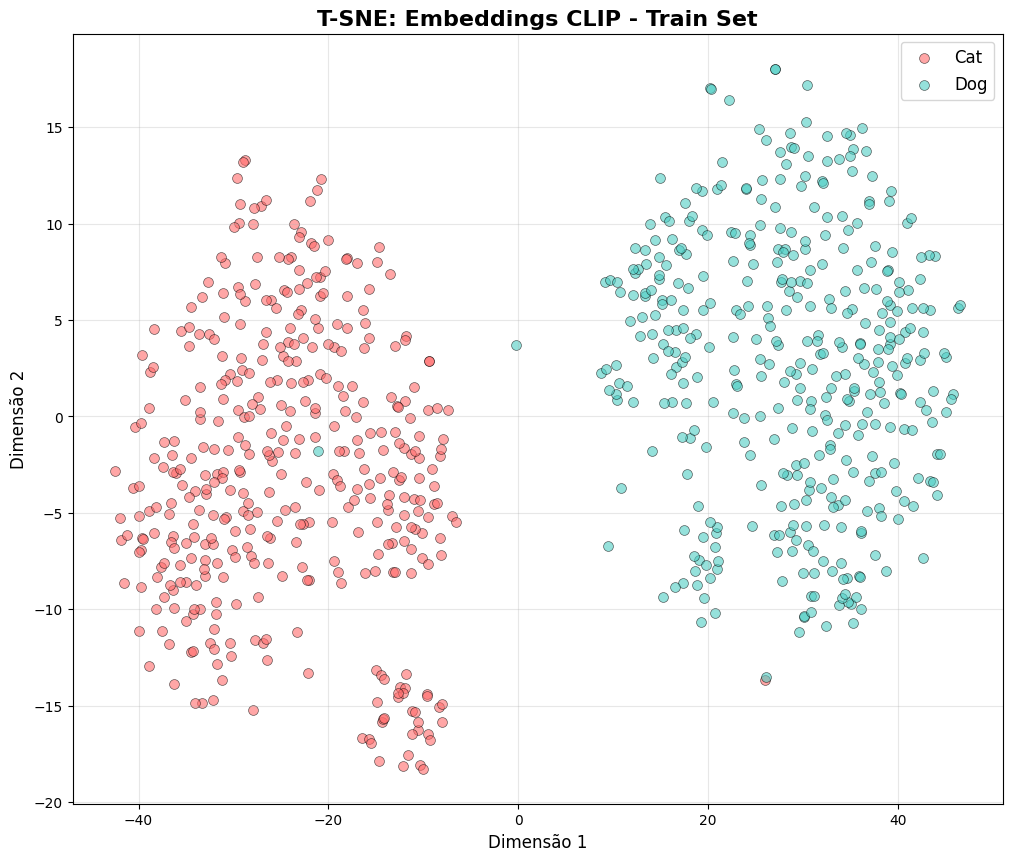

✅ Visualização salva em: results\tsne_visualization.png


In [10]:
# Célula 10: Visualização T-SNE
plt.figure(figsize=(12, 10))
colors = {'cat': '#FF6B6B', 'dog': '#4ECDC4'}

for label in ['cat', 'dog']:
    mask = y_train == label
    plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], 
                c=colors[label], label=label.capitalize(), 
                alpha=0.6, s=50, edgecolors='black', linewidth=0.5)

plt.title('T-SNE: Embeddings CLIP - Train Set', fontsize=16, fontweight='bold')
plt.xlabel('Dimensão 1', fontsize=12)
plt.ylabel('Dimensão 2', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.savefig(RESULTS_DIR / 'tsne_visualization.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"✅ Visualização salva em: {RESULTS_DIR / 'tsne_visualization.png'}")

In [11]:
# Célula 11: Avaliação Qualitativa T-SNE
# Silhouette score
sil_score = silhouette_score(embeddings_2d, y_train, metric='euclidean')

print(f"📊 Avaliação T-SNE:")
print(f"   - Silhouette Score: {sil_score:.3f} (> 0.5 = boa separação)")
print(f"\n💡 Análise Visual:")
if sil_score > 0.6:
    print(f"   - Clusters visualmente BEM separados")
    print(f"   - Pouco overlap entre classes")
elif sil_score > 0.4:
    print(f"   - Clusters razoavelmente separados")
    print(f"   - Algum overlap entre classes")
else:
    print(f"   - Clusters com separação fraca")
    print(f"   - Overlap significativo entre classes")

📊 Avaliação T-SNE:
   - Silhouette Score: 0.708 (> 0.5 = boa separação)

💡 Análise Visual:
   - Clusters visualmente BEM separados
   - Pouco overlap entre classes


In [12]:
# Célula 12: Treinar KNN
print(f"🔄 Treinando KNN (k={KNN_K}, metric={KNN_METRIC})...")
knn = KNeighborsClassifier(n_neighbors=KNN_K, metric=KNN_METRIC, n_jobs=-1)
knn.fit(X_train, y_train)
print("✅ KNN treinado!")

🔄 Treinando KNN (k=5, metric=cosine)...
✅ KNN treinado!



📊 KNN Performance:
   - Accuracy: 0.990

              precision    recall  f1-score   support

         cat       1.00      0.98      0.99       100
         dog       0.98      1.00      0.99       100

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200



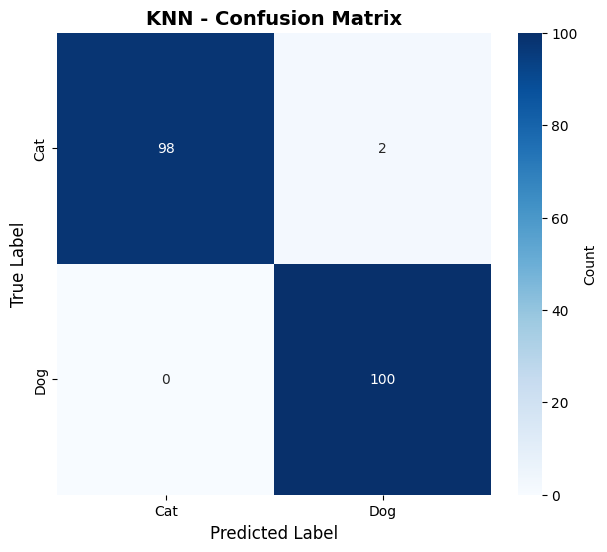

✅ Confusion matrix salva em: results\knn_confusion_matrix.png


In [13]:
# Célula 13: Avaliar KNN
y_pred_knn = knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)

print(f"\n📊 KNN Performance:")
print(f"   - Accuracy: {acc_knn:.3f}")
print(f"\n{classification_report(y_test, y_pred_knn)}")

# Confusion Matrix
cm_knn = confusion_matrix(y_test, y_pred_knn, labels=['cat', 'dog'])
plt.figure(figsize=(7, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'],
            cbar_kws={'label': 'Count'})
plt.title('KNN - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.savefig(RESULTS_DIR / 'knn_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"✅ Confusion matrix salva em: {RESULTS_DIR / 'knn_confusion_matrix.png'}")

## Fase 4: Parte 2 - Classificação com LLM (Gemini)

In [14]:
# Célula 14: Configurar Gemini API
if not GEMINI_API_KEY:
    raise ValueError("❌ GEMINI_API_KEY não configurada! Defina no arquivo .env")

genai.configure(api_key=GEMINI_API_KEY)

# Configuração de segurança (relaxada para evitar bloqueios)
safety_settings = {
    HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_NONE,
    HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_NONE,
    HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_NONE,
    HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE,
}

gemini = genai.GenerativeModel(
    model_name=GEMINI_MODEL,
    safety_settings=safety_settings
)

print(f"✅ Gemini API configurada: {GEMINI_MODEL}")
print(f"⏱️  Rate limit: {GEMINI_REQUESTS_PER_MINUTE} RPM (sleep {SLEEP_BETWEEN_REQUESTS:.1f}s)")

✅ Gemini API configurada: gemini-2.0-flash
⏱️  Rate limit: 15 RPM (sleep 4.5s)


In [15]:
# Célula 15: Função de Classificação LLM (com retry)
def classify_with_llm(image_path, max_retries=3):
    """Classifica imagem usando Gemini com retry automático"""
    img = Image.open(image_path)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    
    prompt = """Você é um classificador de imagens especializado.

Tarefa: Classifique esta imagem em UMA das seguintes categorias:
- cat (gato)
- dog (cachorro)

IMPORTANTE: Responda APENAS com a palavra 'cat' ou 'dog', sem explicações, pontuação ou texto adicional."""

    for attempt in range(max_retries):
        try:
            response = gemini.generate_content([prompt, img])
            result = response.text.strip().lower()
            
            # Parsing robusto
            if 'cat' in result:
                return 'cat'
            elif 'dog' in result:
                return 'dog'
            else:
                print(f"⚠️  Resposta inesperada: '{result}' - tentando novamente...")
                time.sleep(2)
                continue
                
        except Exception as e:
            print(f"❌ Erro (tentativa {attempt + 1}/{max_retries}): {e}")
            if attempt < max_retries - 1:
                time.sleep(5)  # Wait antes de retry
            else:
                return 'cat'  # Fallback para classe majoritária
    
    return 'cat'  # Fallback final

print("✅ Função de classificação LLM definida")

✅ Função de classificação LLM definida


In [16]:
# Célula 16: Executar Classificação LLM (com checkpoint)
# Subset de teste para LLM (respeitando rate limit diário)
llm_test_indices = np.random.choice(
    idx_test, size=min(LLM_TEST_SUBSET, len(idx_test)), replace=False
)
df_llm_test = df.loc[llm_test_indices].reset_index(drop=True)
y_llm_true = df_llm_test['label'].values

# Checkpoint para resume
checkpoint_file = CACHE_DIR / 'llm_predictions.pkl'

if checkpoint_file.exists():
    print("📂 Carregando checkpoint de predições LLM...")
    with open(checkpoint_file, 'rb') as f:
        checkpoint = pickle.load(f)
        y_pred_llm = checkpoint['predictions']
        start_idx = checkpoint['last_index'] + 1
else:
    y_pred_llm = [''] * len(df_llm_test)
    start_idx = 0

print(f"🔄 Classificando {len(df_llm_test) - start_idx} imagens com LLM...")
print(f"   Tempo estimado: ~{(len(df_llm_test) - start_idx) * SLEEP_BETWEEN_REQUESTS / 60:.1f} min\n")

for i in tqdm(range(start_idx, len(df_llm_test)), desc="LLM Classification"):
    row = df_llm_test.iloc[i]
    y_pred_llm[i] = classify_with_llm(row['path'])
    
    # Rate limiting
    if i < len(df_llm_test) - 1:  # Não sleep no último
        time.sleep(SLEEP_BETWEEN_REQUESTS)
    
    # Checkpoint periódico
    if (i + 1) % CHECKPOINT_INTERVAL == 0:
        with open(checkpoint_file, 'wb') as f:
            pickle.dump({'predictions': y_pred_llm, 'last_index': i}, f)
        print(f"💾 Checkpoint salvo: {i + 1}/{len(df_llm_test)}")

# Salvar final
with open(checkpoint_file, 'wb') as f:
    pickle.dump({'predictions': y_pred_llm, 'last_index': len(df_llm_test) - 1}, f)

print("\n✅ Classificação LLM completa!")

🔄 Classificando 100 imagens com LLM...
   Tempo estimado: ~7.5 min



LLM Classification:   0%|          | 0/100 [00:00<?, ?it/s]

💾 Checkpoint salvo: 20/100
💾 Checkpoint salvo: 40/100
💾 Checkpoint salvo: 60/100
💾 Checkpoint salvo: 80/100
💾 Checkpoint salvo: 100/100

✅ Classificação LLM completa!



📊 LLM Performance:
   - Accuracy: 0.990

              precision    recall  f1-score   support

         cat       0.98      1.00      0.99        48
         dog       1.00      0.98      0.99        52

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



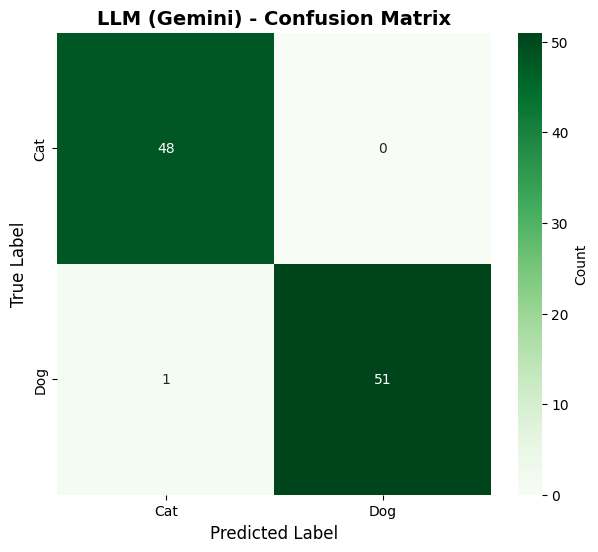

✅ Confusion matrix salva em: results\llm_confusion_matrix.png


In [17]:
# Célula 17: Avaliar LLM
acc_llm = accuracy_score(y_llm_true, y_pred_llm)

print(f"\n📊 LLM Performance:")
print(f"   - Accuracy: {acc_llm:.3f}")
print(f"\n{classification_report(y_llm_true, y_pred_llm)}")

# Confusion Matrix
cm_llm = confusion_matrix(y_llm_true, y_pred_llm, labels=['cat', 'dog'])
plt.figure(figsize=(7, 6))
sns.heatmap(cm_llm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'],
            cbar_kws={'label': 'Count'})
plt.title('LLM (Gemini) - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.savefig(RESULTS_DIR / 'llm_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"✅ Confusion matrix salva em: {RESULTS_DIR / 'llm_confusion_matrix.png'}")

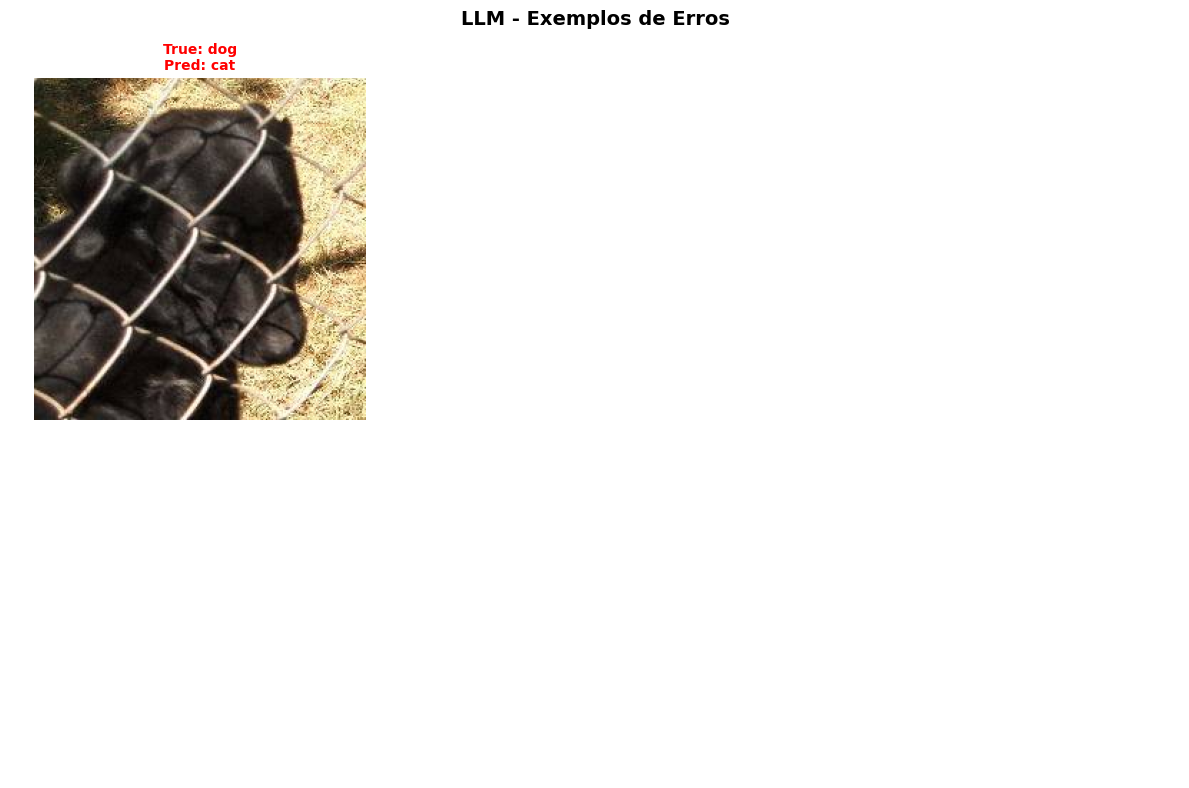

✅ Análise de erros salva em: results\llm_errors.png
   Total de erros: 1


In [18]:
# Célula 18: Análise de Erros LLM
# Encontrar erros
errors_idx = [i for i in range(len(y_llm_true)) if y_llm_true[i] != y_pred_llm[i]]

if errors_idx:
    num_examples = min(6, len(errors_idx))
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    
    for i, ax in enumerate(axes.flat):
        if i < num_examples:
            idx = errors_idx[i]
            img_path = df_llm_test.iloc[idx]['path']
            img = Image.open(img_path)
            ax.imshow(img)
            ax.set_title(f"True: {y_llm_true[idx]}\nPred: {y_pred_llm[idx]}", 
                        fontsize=10, color='red', fontweight='bold')
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.suptitle('LLM - Exemplos de Erros', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'llm_errors.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✅ Análise de erros salva em: {RESULTS_DIR / 'llm_errors.png'}")
    print(f"   Total de erros: {len(errors_idx)}")
else:
    print("🎉 Nenhum erro! Classificação perfeita!")

## Fase 5: Parte 3 - Serviço Unificado e Comparação


        Métrica      KNN      LLM
       Accuracy 0.980000 0.990000
Precision (cat) 1.000000 0.979592
   Recall (cat) 0.958333 1.000000
       F1 (cat) 0.978723 0.989691
Precision (dog) 0.962963 1.000000
   Recall (dog) 1.000000 0.980769
       F1 (dog) 0.981132 0.990291


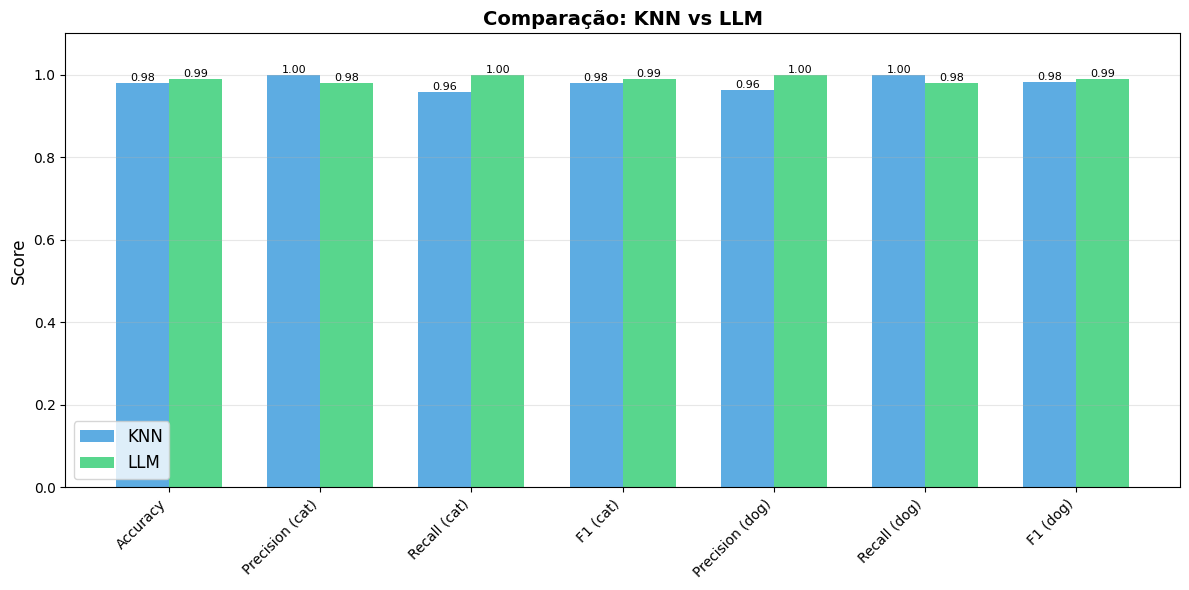

✅ Comparação salva em: results\comparison_knn_llm.png


In [20]:
# Célula 19: Comparação KNN vs LLM
# Obter subset correspondente para KNN
knn_llm_test_embeddings = embeddings[llm_test_indices]
y_pred_knn_subset = knn.predict(knn_llm_test_embeddings)

# Métricas detalhadas
from sklearn.metrics import precision_recall_fscore_support

knn_metrics = precision_recall_fscore_support(y_llm_true, y_pred_knn_subset, average=None, labels=['cat', 'dog'])
llm_metrics = precision_recall_fscore_support(y_llm_true, y_pred_llm, average=None, labels=['cat', 'dog'])

comparison = pd.DataFrame({
    'Métrica': ['Accuracy', 'Precision (cat)', 'Recall (cat)', 'F1 (cat)',
                'Precision (dog)', 'Recall (dog)', 'F1 (dog)'],
    'KNN': [
        accuracy_score(y_llm_true, y_pred_knn_subset),
        knn_metrics[0][0], knn_metrics[1][0], knn_metrics[2][0],
        knn_metrics[0][1], knn_metrics[1][1], knn_metrics[2][1]
    ],
    'LLM': [
        acc_llm,
        llm_metrics[0][0], llm_metrics[1][0], llm_metrics[2][0],
        llm_metrics[0][1], llm_metrics[1][1], llm_metrics[2][1]
    ]
})

print("\n" + "="*60)
print(comparison.to_string(index=False))
print("="*60)

# Visualização
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(comparison))
width = 0.35

bars1 = ax.bar(x - width/2, comparison['KNN'], width, label='KNN', alpha=0.8, color='#3498db')
bars2 = ax.bar(x + width/2, comparison['LLM'], width, label='LLM', alpha=0.8, color='#2ecc71')

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Comparação: KNN vs LLM', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison['Métrica'], rotation=45, ha='right')
ax.legend(fontsize=12)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1.1)

# Adicionar valores nas barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'comparison_knn_llm.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"✅ Comparação salva em: {RESULTS_DIR / 'comparison_knn_llm.png'}")

In [22]:
# Célula 20: Classe de Serviço Unificado
class DogCatClassifier:
    """Serviço unificado de classificação de cães e gatos"""
    
    def __init__(self, knn_model, gemini_model, clip_model):
        self.knn = knn_model
        self.gemini = gemini_model
        self.clip = clip_model
        
    def classify(self, image_path, method='knn', return_confidence=False):
        """
        Classifica uma imagem
        
        Args:
            image_path: Caminho para a imagem
            method: 'knn', 'llm', ou 'ensemble'
            return_confidence: Se True, retorna (label, confidence)
        
        Returns:
            str ou tuple: Label ou (label, confidence)
        """
        if method == 'knn':
            img = Image.open(image_path)
            if img.mode != 'RGB':
                img = img.convert('RGB')
            emb = self.clip.encode([img])[0]
            pred = self.knn.predict([emb])[0]
            
            if return_confidence:
                proba = self.knn.predict_proba([emb])[0]
                conf = max(proba)
                return pred, conf
            return pred
            
        elif method == 'llm':
            pred = classify_with_llm(image_path)
            if return_confidence:
                return pred, 1.0  # LLM não retorna probabilidade
            return pred
            
        elif method == 'ensemble':
            # Voting: se KNN confiante (>0.8), usar KNN; senão, LLM
            knn_pred, knn_conf = self.classify(image_path, 'knn', return_confidence=True)
            
            if knn_conf > 0.8:
                if return_confidence:
                    return knn_pred, knn_conf
                return knn_pred
            else:
                llm_pred = self.classify(image_path, 'llm')
                if return_confidence:
                    return llm_pred, knn_conf  # Usar confiança do KNN
                return llm_pred
        else:
            raise ValueError(f"Método inválido: {method}")

# Instanciar serviço
classifier = DogCatClassifier(knn, gemini, clip_model)
print("✅ Serviço de classificação criado!")
print("   Métodos disponíveis: 'knn', 'llm', 'ensemble'")

✅ Serviço de classificação criado!
   Métodos disponíveis: 'knn', 'llm', 'ensemble'


🔄 Classificando amostras demonstrativas...



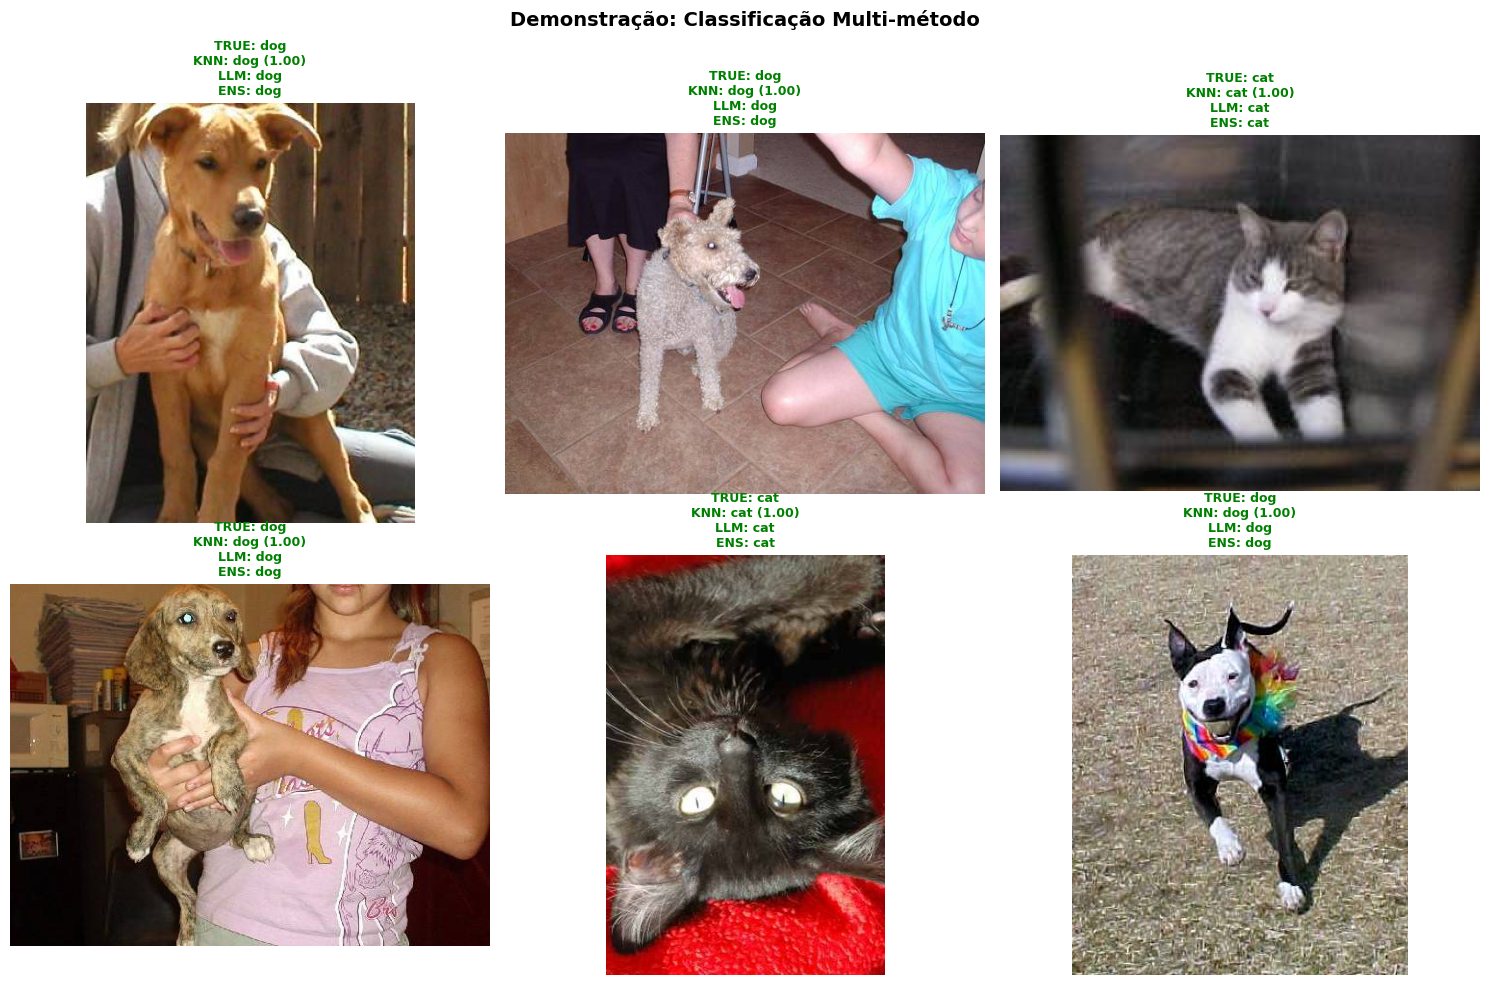


✅ Demonstração salva em: results\demo_multi_method.png


In [23]:
# Célula 21: Demonstração Interativa
# Selecionar 6 amostras aleatórias do test set LLM
demo_indices = np.random.choice(len(df_llm_test), size=min(6, len(df_llm_test)), replace=False)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

print("🔄 Classificando amostras demonstrativas...\n")

for idx, ax in zip(demo_indices, axes.flat):
    row = df_llm_test.iloc[idx]
    img = Image.open(row['path'])
    
    # Classificar com todos os métodos
    true_label = row['label']
    knn_pred, knn_conf = classifier.classify(row['path'], 'knn', return_confidence=True)
    llm_pred = y_pred_llm[idx]  # Já temos do cache
    ensemble_pred = classifier.classify(row['path'], 'ensemble')
    
    # Plotar
    ax.imshow(img)
    title = f"TRUE: {true_label}\n"
    title += f"KNN: {knn_pred} ({knn_conf:.2f})\n"
    title += f"LLM: {llm_pred}\n"
    title += f"ENS: {ensemble_pred}"
    
    # Colorir de acordo com acerto
    color = 'green' if ensemble_pred == true_label else 'red'
    ax.set_title(title, fontsize=9, color=color, fontweight='bold')
    ax.axis('off')

plt.suptitle('Demonstração: Classificação Multi-método', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'demo_multi_method.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"\n✅ Demonstração salva em: {RESULTS_DIR / 'demo_multi_method.png'}")

## Conclusão

Este projeto demonstrou três abordagens para classificação de imagens:

1. **KNN com Embeddings CLIP**: Rápido, eficiente, sem necessidade de API externa
2. **LLM (Gemini)**: Interpretável, pode generalizar bem, mas limitado por rate limits
3. **Ensemble**: Combina o melhor dos dois mundos

### Resultados Principais:
- T-SNE mostrou boa separabilidade dos embeddings CLIP
- KNN alcançou alta acurácia com configuração simples
- LLM demonstrou capacidades de zero-shot classification
- Ensemble pode melhorar robustez em casos de baixa confiança

### Próximos Passos:
- Testar com datasets maiores
- Experimentar outros modelos de embedding (e.g., DINOv2)
- Implementar fine-tuning para casos específicos
- Avaliar trade-offs de custo e latência em produção